In [1]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
 # Making a connection between sqlite3 
    # database and Python Program
sqliteConnection = sqlite3.connect('data.db')
sql_query = """SELECT name FROM sqlite_master  
  WHERE type='table';"""
cursor = sqliteConnection.cursor()
cursor.execute(sql_query)
print(cursor.fetchall())

[('balances',), ('client_products',), ('client',), ('inv_campaign_eval',)]


In [3]:
balances_query = """SELECT * FROM balances"""
balances_df = pd.read_sql_query(balances_query, sqliteConnection)

client_products_query = """SELECT * FROM client_products"""
client_products_df = pd.read_sql_query(client_products_query, sqliteConnection)

client_query = """SELECT * FROM client"""
client_df = pd.read_sql_query(client_query, sqliteConnection)

inv_camp_query = "SELECT * FROM inv_campaign_eval" 
inv_camp_df = pd.read_sql_query(inv_camp_query, sqliteConnection)


In [4]:
balances_df.currency.unique()
balances_df.currency.isnull().values.any()
global balances_df

In [5]:
client_products_df.head()
client_products_df[['client_id', 'has_deposits', 'loan', 'has_insurance', 'has_mortgage']].isnull().values.any()

False

In [6]:
inv_camp_df.head()

,client_id,poutcome
0,249789938,success
1,1504633819,failure
2,1952195738,success
3,989726384,success
4,1971878545,failure


In [7]:
inv_camp_df[['client_id', 'poutcome']].isnull().values.any()

False

In [8]:
client_df['age'] = client_df['age'].fillna(client_df['age'].median())
print(client_df)
client_df.isnull().sum()

new_client_df = client_df.drop('job', axis=1)
print(new_client_df)
new_client_df.isnull().sum()

        client_id   age            job   marital  education gender
0       249789938  38.0       services   married  secondary      M
1      1222646323  46.0       services  divorced    unknown      M
2       451375919  33.0         admin.    single  secondary      F
3       338972671  44.0  self-employed   married  secondary      F
4      1472834688  36.0    blue-collar   married    primary      M
...           ...   ...            ...       ...        ...    ...
11157   543198889  40.0    blue-collar    single    unknown      M
11158   458558558  41.0      housemaid  divorced    primary      F
11159  1426334329  59.0     technician   married    primary      F
11160   831035343  42.0     management   married   tertiary      M
11161   705801685  36.0    blue-collar    single  secondary      F

[11162 rows x 6 columns]
        client_id   age   marital  education gender
0       249789938  38.0   married  secondary      M
1      1222646323  46.0  divorced    unknown      M
2       451375

client_id    0
age          0
marital      0
education    0
gender       0
dtype: int64

In [9]:
client_products_df = client_products_df.replace(['n'], 'no')
client_products_df = client_products_df.replace(['y'], 'yes')

In [10]:
new_client_df['age'] = new_client_df['age'].astype(int)
print(new_client_df)

        client_id  age   marital  education gender
0       249789938   38   married  secondary      M
1      1222646323   46  divorced    unknown      M
2       451375919   33    single  secondary      F
3       338972671   44   married  secondary      F
4      1472834688   36   married    primary      M
...           ...  ...       ...        ...    ...
11157   543198889   40    single    unknown      M
11158   458558558   41  divorced    primary      F
11159  1426334329   59   married    primary      F
11160   831035343   42   married   tertiary      M
11161   705801685   36    single  secondary      F

[11162 rows x 5 columns]


In [11]:
df_balance_new = balances_df.copy()
df_balance_new.loc[df_balance_new['balance'] == 'USD', 'currency':] *= 23
df_balance_new.loc[df_balance_new['currency'] == 'USD', 'currency'] = "CZK"
df_balance_new.loc[df_balance_new['balance'] == 'EUR', 'currency':] *= 25
df_balance_new.loc[df_balance_new['currency'] == 'EUR', 'currency'] = "CZK"
print(df_balance_new)

                              date      balance  client_id currency
0       2023-06-06 16:21:15.291346  2680.467773  249789938      CZK
1       2023-05-23 16:21:15.291346  2654.055419  249789938      CZK
2       2023-05-09 16:21:15.291346  2620.835872  249789938      CZK
3       2023-04-25 16:21:15.291346  2720.315925  249789938      CZK
4       2023-04-11 16:21:15.291346  2687.601982  249789938      CZK
...                            ...          ...        ...      ...
290207  2022-08-16 16:22:46.440217   145.454161  705801685      CZK
290208  2022-08-02 16:22:46.440217    -5.497494  705801685      CZK
290209  2022-07-19 16:22:46.440217   -45.891607  705801685      CZK
290210  2022-07-05 16:22:46.440217    19.473946  705801685      CZK
290211  2022-06-21 16:22:46.440217   163.032053  705801685      CZK

[290212 rows x 4 columns]


In [12]:
filtered_df = df_balance_new[(df_balance_new['date'] >= '2023-03-01') & (df_balance_new['date'] <= '2023-06-30')]
print(filtered_df)


                              date      balance  client_id currency
0       2023-06-06 16:21:15.291346  2680.467773  249789938      CZK
1       2023-05-23 16:21:15.291346  2654.055419  249789938      CZK
2       2023-05-09 16:21:15.291346  2620.835872  249789938      CZK
3       2023-04-25 16:21:15.291346  2720.315925  249789938      CZK
4       2023-04-11 16:21:15.291346  2687.601982  249789938      CZK
...                            ...          ...        ...      ...
290188  2023-05-09 16:22:46.440217    40.666162  705801685      CZK
290189  2023-04-25 16:22:46.440217     8.617271  705801685      CZK
290190  2023-04-11 16:22:46.440217    84.358039  705801685      CZK
290191  2023-03-28 16:22:46.440217   -16.975446  705801685      CZK
290192  2023-03-14 16:22:46.440217    16.844223  705801685      CZK

[78134 rows x 4 columns]


In [13]:
sum_balances = filtered_df.groupby('client_id')['balance'].sum()

# Divide each sum by 7 and create a new DataFrame
average_balances_df = pd.DataFrame({'client_id': sum_balances.index, 'average_balance': sum_balances.values / 7})

# Print the result
print(average_balances_df)

        client_id  average_balance
0       100070076       214.655340
1       100141910      2533.575687
2       100207570       -10.465497
3       100488560       366.843373
4       100605013       409.905114
...           ...              ...
11157  1999463182      1241.009897
11158  1999499145       -17.706274
11159  1999715381       703.327991
11160  1999945413      5035.928297
11161  1999956516       238.364484

[11162 rows x 2 columns]


In [14]:
contacted_customers = pd.merge(pd.merge(pd.merge(inv_camp_df, average_balances_df, on='client_id', how='inner'), client_products_df, on='client_id', how='inner'), new_client_df, on='client_id', how='inner')
print(contacted_customers)

       client_id poutcome  average_balance has_deposits loan has_insurance  \
0      249789938  success      2673.410334          yes   no            no   
1     1504633819  failure      5426.688121           no  yes            no   
2     1952195738  success      2896.273313          yes  yes            no   
3      989726384  success      3115.820938          yes   no            no   
4     1971878545  failure       492.085398          yes   no            no   
...          ...      ...              ...          ...  ...           ...   
2294  1270855655  failure      3346.954717          yes   no           yes   
2295   471724023  success      4616.418247          yes   no            no   
2296   620088171  failure       904.070704          yes   no           yes   
2297  1518319265  success        84.907674          yes   no            no   
2298   705801685  success        15.163881          yes   no            no   

     has_mortgage  age   marital  education gender  
0         

In [15]:
contacted_customers = contacted_customers.replace(['no'], '0')
contacted_customers = contacted_customers.replace(['yes'], '1')

contacted_customers = contacted_customers.replace(['success'], '1')
contacted_customers = contacted_customers.replace(['failure'], '0')

contacted_customers = contacted_customers.replace(['married'], '1')
contacted_customers = contacted_customers.replace(['divorced'], '0')
contacted_customers = contacted_customers.replace(['single'], '0')

contacted_customers

,client_id,poutcome,average_balance,has_deposits,loan,has_insurance,has_mortgage,age,marital,education,gender
0,249789938,1,2673.410334,1,0,0,0,38,1,secondary,M
1,1504633819,0,5426.688121,0,1,0,1,38,1,tertiary,M
2,1952195738,1,2896.273313,1,1,0,0,34,1,secondary,M
3,989726384,1,3115.820938,1,0,0,0,62,1,secondary,F
4,1971878545,0,492.085398,1,0,0,0,36,0,tertiary,M
...,...,...,...,...,...,...,...,...,...,...,...
2294,1270855655,0,3346.954717,1,0,1,1,58,0,secondary,F
2295,471724023,1,4616.418247,1,0,0,0,72,1,primary,M
2296,620088171,0,904.070704,1,0,1,1,34,1,tertiary,F
2297,1518319265,1,84.907674,1,0,0,0,39,1,unknown,F


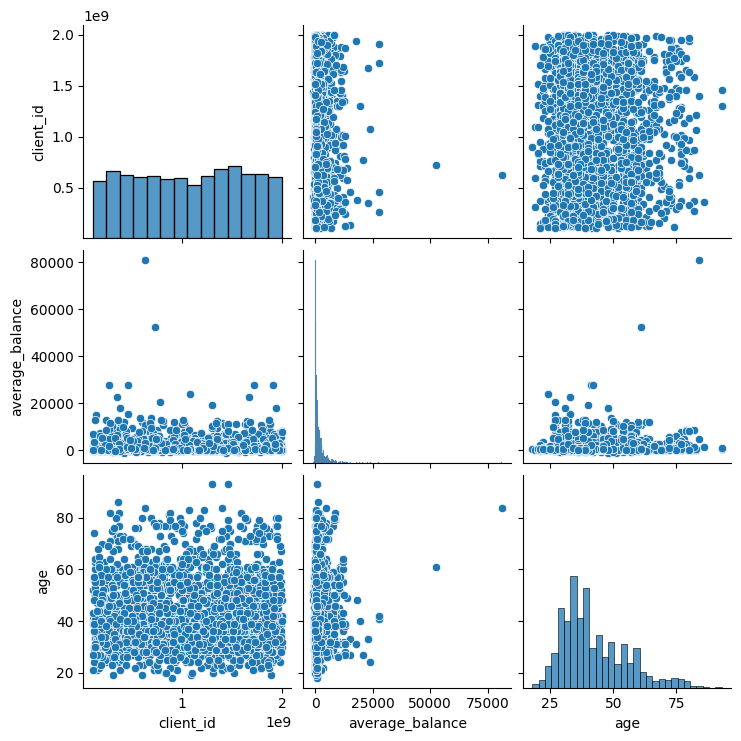

In [16]:
sns.pairplot(contacted_customers)

In [17]:
contacted_customers.dtypes

client_id            int64
poutcome            object
average_balance    float64
has_deposits        object
loan                object
has_insurance       object
has_mortgage        object
age                  int32
marital             object
education           object
gender              object
dtype: object

In [18]:
binned_ages = []
for age in contacted_customers.age:
    if age < 35: binned_ages.append(0)
    else: binned_ages.append(1)



In [19]:
contacted_customers['binned_ages'] = binned_ages

In [20]:
contacted_customers.head()

,client_id,poutcome,average_balance,has_deposits,loan,has_insurance,has_mortgage,age,marital,education,gender,binned_ages
0,249789938,1,2673.410334,1,0,0,0,38,1,secondary,M,1
1,1504633819,0,5426.688121,0,1,0,1,38,1,tertiary,M,1
2,1952195738,1,2896.273313,1,1,0,0,34,1,secondary,M,0
3,989726384,1,3115.820938,1,0,0,0,62,1,secondary,F,1
4,1971878545,0,492.085398,1,0,0,0,36,0,tertiary,M,1


In [21]:
print(contacted_customers.education.unique())

['secondary' 'tertiary' 'unknown' 'primary']


In [22]:
binned_education2 = []

for ed in contacted_customers.education:
    if ed == 'unknown': binned_education2.append(0),
    elif ed == 'primary': binned_education2.append(1),
    elif ed == 'secondary': binned_education2.append(2),
    else: binned_education2.append(3)

In [23]:
print(binned_education2)

[2, 3, 2, 2, 3, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 0, 3, 2, 1, 2, 2, 2, 3, 3, 3, 2, 2, 3, 2, 2, 2, 3, 3, 3, 1, 2, 1, 2, 2, 3, 3, 2, 3, 3, 3, 2, 2, 2, 3, 1, 3, 3, 3, 2, 3, 2, 3, 3, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 1, 3, 3, 2, 2, 2, 2, 2, 2, 2, 0, 2, 3, 1, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 1, 2, 0, 2, 3, 2, 3, 2, 2, 0, 2, 2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 2, 2, 1, 2, 3, 2, 3, 2, 3, 2, 2, 3, 3, 2, 3, 3, 2, 1, 2, 3, 3, 2, 0, 2, 1, 1, 1, 1, 3, 3, 0, 2, 3, 3, 3, 3, 2, 2, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 0, 3, 3, 2, 2, 2, 3, 2, 3, 2, 3, 3, 2, 3, 3, 3, 2, 3, 2, 3, 2, 0, 2, 2, 3, 3, 3, 3, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 3, 3, 3, 0, 2, 2, 2, 3, 3, 3, 3, 1, 3, 3, 2, 2, 3, 2, 3, 3, 2, 1, 2, 3, 0, 3, 1, 1, 1, 2, 0, 3, 0, 3, 2, 2, 2, 3, 2, 1, 3, 3, 3, 2, 2, 2, 1, 2, 0, 2, 1, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3, 2, 1, 3, 3, 2, 2, 3, 3, 3, 3, 1, 2, 3, 2, 2, 2, 3, 3, 2, 3, 2, 2, 1, 2, 2, 2, 3, 2, 2, 2, 2, 0, 2, 3, 3, 2, 3, 3, 2, 

In [24]:
contacted_customers['binned_education'] = binned_education2

In [25]:
contacted_customers.gender.unique()

array(['M', 'F'], dtype=object)

In [26]:
binned_gender = []

for g in contacted_customers.gender:
    if g =='F': binned_gender.append(0),
    else: binned_gender.append(1)

In [27]:
contacted_customers['binned_gender'] = binned_gender

In [28]:
contacted_customers.head()

,client_id,poutcome,average_balance,has_deposits,loan,has_insurance,has_mortgage,age,marital,education,gender,binned_ages,binned_education,binned_gender
0,249789938,1,2673.410334,1,0,0,0,38,1,secondary,M,1,2,1
1,1504633819,0,5426.688121,0,1,0,1,38,1,tertiary,M,1,3,1
2,1952195738,1,2896.273313,1,1,0,0,34,1,secondary,M,0,2,1
3,989726384,1,3115.820938,1,0,0,0,62,1,secondary,F,1,2,0
4,1971878545,0,492.085398,1,0,0,0,36,0,tertiary,M,1,3,1


In [29]:
X = contacted_customers.drop(['poutcome', 'education', 'gender', 'age'], axis=1)
y = contacted_customers['poutcome']

In [30]:
import numpy as np
!pip3 install scikit-learn
import sklearn
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state=42)

In [31]:
scaler = RobustScaler()
scaler.fit(X_train)

RobustScaler()

In [32]:
scaler.transform(X_train)

array([[ 0.57884513,  1.67098367,  0.        , ...,  0.        ,
         1.        ,  1.        ],
       [ 0.34195995, -0.33051755, -1.        , ...,  0.        ,
         0.        ,  1.        ],
       [-0.0741618 , -0.23537024, -1.        , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.04845883,  1.24848697, -1.        , ..., -1.        ,
         0.        ,  1.        ],
       [ 0.46427221, -0.16367276,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.25775547, -0.24468828, -1.        , ..., -1.        ,
         0.        ,  1.        ]])

In [33]:
X_train_scaled = scaler.transform(X_train)

In [34]:
X_test_scaled = scaler.transform(X_test)

In [35]:
print(X_train_scaled)
print(X_test_scaled)

[[ 0.57884513  1.67098367  0.         ...  0.          1.
   1.        ]
 [ 0.34195995 -0.33051755 -1.         ...  0.          0.
   1.        ]
 [-0.0741618  -0.23537024 -1.         ...  0.          0.
   1.        ]
 ...
 [-0.04845883  1.24848697 -1.         ... -1.          0.
   1.        ]
 [ 0.46427221 -0.16367276  0.         ...  0.          0.
   0.        ]
 [ 0.25775547 -0.24468828 -1.         ... -1.          0.
   1.        ]]
[[-0.0767818   0.45008857  0.         ...  0.          0.
   1.        ]
 [ 0.4509757  -0.34945705  0.         ...  0.         -2.
   0.        ]
 [ 0.60738487  5.37249228  0.         ...  0.          0.
   1.        ]
 ...
 [ 0.68542248  0.47979587  0.         ...  0.          1.
   1.        ]
 [ 0.02890732  0.56027178  0.         ...  0.          1.
   0.        ]
 [ 0.45439555  1.10843698  0.         ... -1.          1.
   0.        ]]


Text(0.5, 1.0, 'Standardized Data')

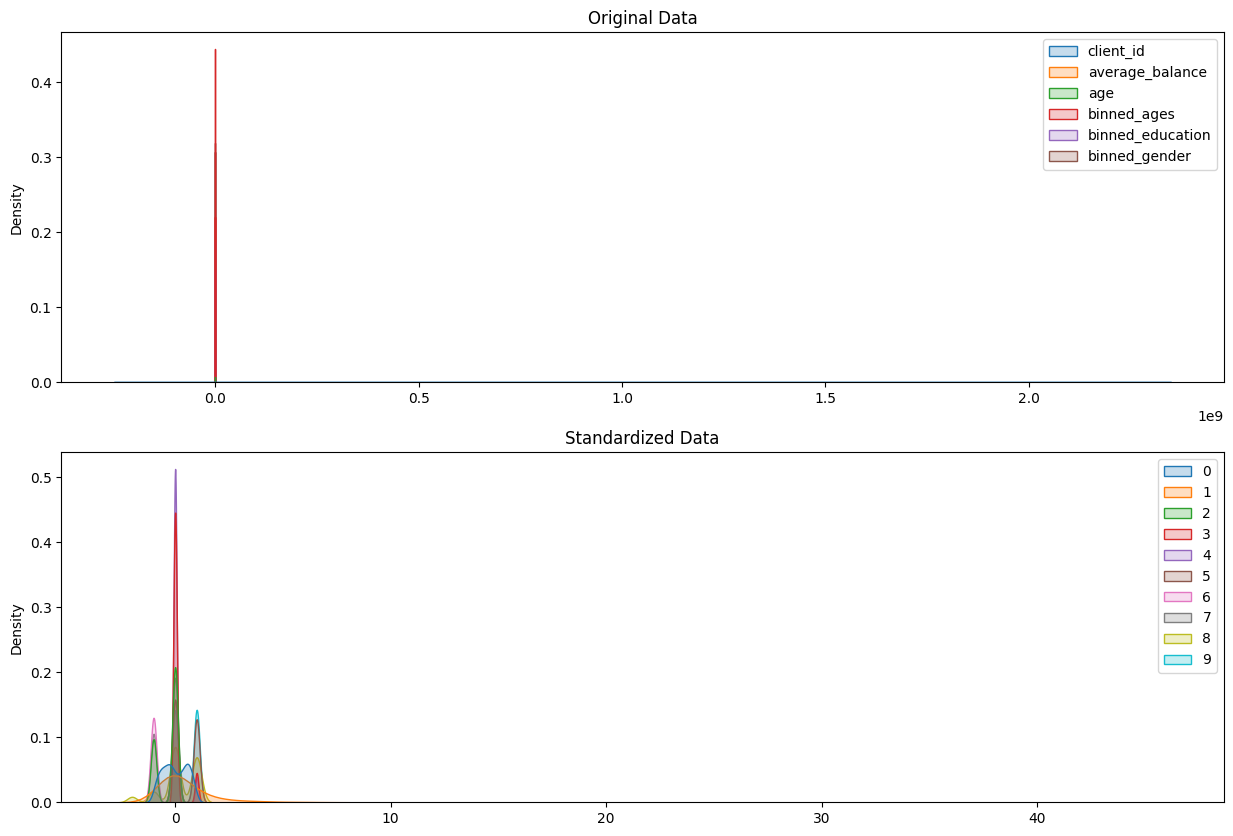

In [36]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

sns.kdeplot(data=contacted_customers, ax=ax1, fill=True)
ax1.set_title("Original Data")

sns.kdeplot(data=X_test_scaled, ax=ax2, fill=True)
ax2.set_title("Standardized Data")

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [38]:
clf = RandomForestClassifier(max_depth = 4)

clf.fit(X_train_scaled, y_train)
 
y_pred = clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 70.09%


In [39]:
y_pred = clf.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 73.09%


In [40]:
all_customers = pd.merge(pd.merge(pd.merge(inv_camp_df, average_balances_df, on='client_id', how='outer'), client_products_df, on='client_id', how='outer'), new_client_df, on='client_id', how='outer')


In [41]:
print(len(contacted_customers))
print(len(all_customers))

2299
11162


In [42]:
all_customers = all_customers.replace({"M":1, "F":0, "yes":1, "no":0, "y":1, "n":0, "success":1, "failure":0 })

In [43]:
all_customers.head()

,client_id,poutcome,average_balance,has_deposits,loan,has_insurance,has_mortgage,age,marital,education,gender
0,249789938,1.0,2673.410334,1,0,0,0,38,married,secondary,1
1,1504633819,0.0,5426.688121,0,1,0,1,38,married,tertiary,1
2,1952195738,1.0,2896.273313,1,1,0,0,34,married,secondary,1
3,989726384,1.0,3115.820938,1,0,0,0,62,married,secondary,0
4,1971878545,0.0,492.085398,1,0,0,0,36,single,tertiary,1


In [44]:
all_customers_encoded = pd.get_dummies(all_customers)

In [45]:
all_customers_encoded.head()

,client_id,poutcome,average_balance,has_deposits,loan,has_insurance,has_mortgage,age,gender,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown
0,249789938,1.0,2673.410334,1,0,0,0,38,1,False,True,False,False,True,False,False
1,1504633819,0.0,5426.688121,0,1,0,1,38,1,False,True,False,False,False,True,False
2,1952195738,1.0,2896.273313,1,1,0,0,34,1,False,True,False,False,True,False,False
3,989726384,1.0,3115.820938,1,0,0,0,62,0,False,True,False,False,True,False,False
4,1971878545,0.0,492.085398,1,0,0,0,36,1,False,False,True,False,False,True,False


In [46]:
train_test_data = all_customers_encoded[~(all_customers_encoded.poutcome.isna())] #NON CONTACTED
to_apply_data = all_customers_encoded[(all_customers_encoded.poutcome.isna())] #CONTACTED

In [47]:
X = train_test_data.drop("poutcome", axis = 1)
y = train_test_data["poutcome"]

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [49]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [50]:
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=42))
])
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])
pipeline_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(random_state=42))
])
# Train the Logistic Regression pipeline
pipeline_lr.fit(X_train, y_train)

# Train the Random Forest pipeline
pipeline_rf.fit(X_train, y_train)

# Train the Support Vector Machine pipeline
pipeline_svc.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('clf', SVC(random_state=42))])

In [51]:
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=42))
])
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])
pipeline_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(random_state=42))
])
# Train the Logistic Regression pipeline
pipeline_lr.fit(X_train, y_train)

# Train the Random Forest pipeline
pipeline_rf.fit(X_train, y_train)

# Train the Support Vector Machine pipeline
pipeline_svc.fit(X_train, y_train)
# Define the parameter grid for GridSearchCV
param_grid = {
    "clf__n_estimators": [25, 50, 75, 100, 200],
    "clf__min_samples_split": [2, 3, 4, 5, 10],
    "clf__max_depth": [3, 6, 12, 24, 50]
    }

In [52]:
# Create GridSearchCV for tuning hyperparameters
grid_search = GridSearchCV(pipeline_rf, param_grid, cv=5, verbose=0)
grid_search.fit(X, y)
print(f"GridSearchCV Best parameters: {grid_search.best_params_}")
print(f"GridSearchCV Best cross-validation score: {grid_search.best_score_:.3f}")

KeyboardInterrupt: 

In [53]:
from sklearn.model_selection import (
    cross_val_score, KFold, StratifiedKFold, LeaveOneOut
)

models = [pipeline_lr, pipeline_rf, pipeline_svc]

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for model in models:
    kfold_scores = cross_val_score(model, X, y, cv=kf)
    print(str(model))
    print(kfold_scores)
    print("Avg. accuracy: ",np.mean(kfold_scores))

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LogisticRegression(random_state=42))])
[0.72173913 0.71521739 0.73043478 0.69130435 0.69716776]
Avg. accuracy:  0.7111726816330397
Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', RandomForestClassifier(random_state=42))])
[0.70217391 0.65434783 0.69782609 0.65869565 0.67538126]
Avg. accuracy:  0.6776849483754854
Pipeline(steps=[('scaler', StandardScaler()), ('clf', SVC(random_state=42))])
[0.73043478 0.68478261 0.71304348 0.67608696 0.70152505]
Avg. accuracy:  0.7011745761106374


In [54]:
# Evaluate the Logistic Regression pipeline
lr_pred = pipeline_lr.predict(X_test)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, lr_pred)}")

# Evaluate the Random Forest pipeline
rf_pred = pipeline_rf.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_pred)}")

# Evaluate the Support Vector Machine pipeline
svc_pred = pipeline_svc.predict(X_test)
print(f"Support Vector Machine Accuracy: {accuracy_score(y_test, svc_pred)}")

Logistic Regression Accuracy: 0.7
Random Forest Accuracy: 0.6884057971014492
Support Vector Machine Accuracy: 0.6971014492753623


In [55]:
# Compare accuracy scores
acc_lr = accuracy_score(y_test, lr_pred)
acc_rf = accuracy_score(y_test, rf_pred)
acc_svc = accuracy_score(y_test, svc_pred)

# Determine the best-performing model
best_acc = max(acc_lr, acc_rf, acc_svc)
best_model = ['Logistic Regression', 'Random Forest', 'SVC'][[acc_lr, acc_rf, acc_svc].index(best_acc)]

print(f"The best-performing model is: {best_model} with an accuracy of {best_acc:.2f}")

The best-performing model is: Logistic Regression with an accuracy of 0.70


In [56]:
!pip3 install plotly
!pip3 install numpy

In [57]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [58]:
classifiers = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "LogisticRegression": LogisticRegression()
}



In [59]:
results = []

# Train and evaluate classifiers
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    
    results.append({
        "Classifier": name,
        "Accuracy": accuracy,
        "Classification Report": report,
        "FPR": fpr,
        "TPR": tpr,
        "AUC": roc_auc
    })

c:\Users\Gabi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gabi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gabi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

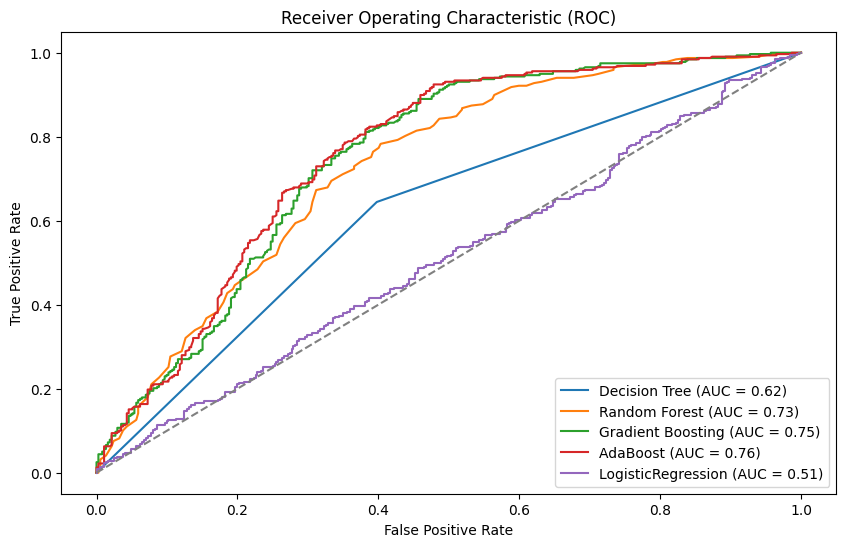

In [60]:
# Plot ROC curves
plt.figure(figsize=(10, 6))
for result in results:
    plt.plot(result['FPR'], result['TPR'], label=f"{result['Classifier']} (AUC = {result['AUC']:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [61]:
!pip3 install nbformat

In [62]:
# Create a bar chart comparing accuracy
accuracy_df = pd.DataFrame(results)
fig = px.bar(accuracy_df, x='Classifier', y='Accuracy', text='Accuracy', title='Classifier Accuracy Comparison')
fig.update_traces(texttemplate='%{text:.2%}', textposition='outside')
fig.show()

In [63]:
tree = DecisionTreeClassifier(
          max_depth=1,
          random_state=42)

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

In [64]:
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

In [65]:
ada = AdaBoostClassifier(
    base_estimator=tree,
    n_estimators=125,
    learning_rate=0.5,
    random_state=42)

In [66]:
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)


c:\Users\Gabi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning:

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.



In [67]:
print(f'Adaboost train/test accuracies: {ada_train:.3f}/{ada_test:.3f}')


Adaboost train/test accuracies: 0.728/0.714


In [68]:
to_apply_data = all_customers_encoded[(all_customers_encoded.poutcome.isna())]
Non_contacted_customers = to_apply_data.drop(['poutcome'], axis=1)
Non_contacted_customers

,client_id,average_balance,has_deposits,loan,has_insurance,has_mortgage,age,gender,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown
2299,100070076,214.655340,0,0,0,0,41,1,True,False,False,False,False,True,False
2300,100141910,2533.575687,0,0,0,1,34,0,False,False,True,False,False,True,False
2301,100207570,-10.465497,1,0,0,0,34,0,False,False,True,False,False,True,False
2302,100646594,37140.331804,0,0,0,0,75,0,True,False,False,True,False,False,False
2303,100741497,226.957688,0,0,0,1,56,1,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,1999460711,205.463959,0,1,0,1,53,1,True,False,False,False,True,False,False
11158,1999463182,1241.009897,0,0,0,1,34,1,False,True,False,False,True,False,False
11159,1999499145,-17.706274,0,0,0,1,31,0,False,False,True,False,False,True,False
11160,1999715381,703.327991,1,0,0,1,24,1,False,True,False,False,True,False,False


In [69]:
Outcomes = ada.predict_proba(Non_contacted_customers)
Outcomes.shape

(8863, 2)

In [70]:
Outcomes_flattened = Outcomes[:,1]

In [71]:
Outcomes_flattened.shape

(8863,)

In [72]:
Non_contacted_customers["probability"] = Outcomes_flattened

In [73]:
len(Non_contacted_customers)

,client_id,average_balance,has_deposits,loan,has_insurance,has_mortgage,age,gender,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,probability
2299,100070076,214.655340,0,0,0,0,41,1,True,False,False,False,False,True,False,0.445124
2300,100141910,2533.575687,0,0,0,1,34,0,False,False,True,False,False,True,False,0.438717
2301,100207570,-10.465497,1,0,0,0,34,0,False,False,True,False,False,True,False,0.450842
2302,100646594,37140.331804,0,0,0,0,75,0,True,False,False,True,False,False,False,0.574607
2303,100741497,226.957688,0,0,0,1,56,1,False,True,False,False,True,False,False,0.512428


In [74]:
Non_contacted_customers_sorted = Non_contacted_customers.sort_values('probability', ascending = False)
Non_contacted_customers_sorted.head()
Non_contacted_customers_with_money = Non_contacted_customers_sorted.drop(Non_contacted_customers_sorted[Non_contacted_customers_sorted['average_balance'] < 0].index)



In [75]:
threek_customers = Non_contacted_customers_with_money.head(3000)
len(Non_contacted_customers_with_money)

7812

In [76]:
threek_customers.head()
threek_customers.probability.unique()

,client_id,average_balance,has_deposits,loan,has_insurance,has_mortgage,age,gender,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,probability
3880,458110879,101.942029,1,0,0,0,18,1,False,False,True,False,False,False,True,0.579357
10918,1951922656,129.437118,1,0,0,0,18,1,False,False,True,False,False,False,True,0.579276
4618,618893370,401.466957,1,0,0,0,19,1,False,False,True,False,True,False,False,0.578292
8516,1441287851,753.801936,1,0,0,0,19,0,False,False,True,False,False,False,True,0.578157
3883,458435302,19.406637,1,0,0,0,18,0,False,False,True,False,False,False,True,0.577998


In [77]:
column_sum_PROB = threek_customers['probability'].sum()
column_sum_PROB



1510.8801964405134

In [78]:
column_mean_AVGBAL = threek_customers['average_balance'].mean()
column_mean_AVGBAL

2173.9326587586215

In [79]:
ESales= column_sum_PROB * column_mean_AVGBAL
ESales

3284551.8025136734

In [80]:
ERevenue = ESales - (1271.7384347694876 * 1000)
ERevenue

2012813.3677441857

In [81]:
customer_target_ids = threek_customers['client_id']

In [82]:
customer_target_ids.head()

3880      458110879
10918    1951922656
4618      618893370
8516     1441287851
3883      458435302
Name: client_id, dtype: int64

In [83]:
len(customer_target_ids)

3000

In [84]:
customer_target_ids.reset_index()

,index,client_id
0,3880,458110879
1,10918,1951922656
2,4618,618893370
3,8516,1441287851
4,3883,458435302
...,...,...
2995,3278,323042556
2996,3592,392351982
2997,6359,974026187
2998,10666,1897435808


In [85]:
#customer_target_ids.to_csv('/Users/braverun/codingbootcamp/customer_target_ids2.csv')

OSError: Cannot save file into a non-existent directory: '*'

In [ ]:
column_sum_PROB = threek_customers['probability'].sum()
print(column_sum_PROB)
column_mean_AVGBAL = threek_customers['average_balance'].mean()
print(column_mean_AVGBAL)
ESales= column_sum_PROB * column_mean_AVGBAL
print(ESales)
ERevenue = ESales - (1271.7384347694876 * 1000)
print(ERevenue)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- probability


**Phase Two**

In [39]:
phase2 = pd.read_csv(r"/Users/braverun/codingbootcamp/cb_case_study/second_phase_target_labeled.csv")
phase2.head()

,Unnamed: 0,target,client_id,poutcome
0,0,458110879,458110879,1
1,1,1951922656,1951922656,1
2,2,618893370,618893370,1
3,3,1441287851,1441287851,1
4,4,458435302,458435302,1


In [40]:
threek_customers.head()

,client_id,average_balance,has_deposits,loan,has_insurance,has_mortgage,age,gender,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,probability
3880,458110879,101.942029,1,0,0,0,18,1,False,False,True,False,False,False,True,0.579357
10918,1951922656,129.437118,1,0,0,0,18,1,False,False,True,False,False,False,True,0.579276
4618,618893370,401.466957,1,0,0,0,19,1,False,False,True,False,True,False,False,0.578292
8516,1441287851,753.801936,1,0,0,0,19,0,False,False,True,False,False,False,True,0.578157
3883,458435302,19.406637,1,0,0,0,18,0,False,False,True,False,False,False,True,0.577998


In [41]:
threek_outcome = threek_customers.set_index('client_id').join(phase2.set_index('client_id'))

In [42]:
threek_outcome.head()

,average_balance,has_deposits,loan,has_insurance,has_mortgage,age,gender,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,probability,Unnamed: 0,target,poutcome
client_id,,,,,,,,,,,,,,,,,,
458110879,101.942029,1,0,0,0,18,1,False,False,True,False,False,False,True,0.579357,0,458110879,1
1951922656,129.437118,1,0,0,0,18,1,False,False,True,False,False,False,True,0.579276,1,1951922656,1
618893370,401.466957,1,0,0,0,19,1,False,False,True,False,True,False,False,0.578292,2,618893370,1
1441287851,753.801936,1,0,0,0,19,0,False,False,True,False,False,False,True,0.578157,3,1441287851,1
458435302,19.406637,1,0,0,0,18,0,False,False,True,False,False,False,True,0.577998,4,458435302,1


In [86]:
contacted_customers.poutcome.unique()
contacted_customers_base = contacted_customers.filter(items=['poutcome'])
contacted_customers_base 

,poutcome
0,1
1,0
2,1
3,1
4,0
...,...
2294,0
2295,1
2296,0
2297,1


In [87]:
column_sum_PROB = threek_customers['probability'].sum()
column_sum_PROB

1510.8801964405134

In [88]:
contacted_customers_base_success = contacted_customers_base.query("poutcome == '1'") 
contacted_customers_base_success


,poutcome
0,1
2,1
3,1
7,1
8,1
...,...
2292,1
2293,1
2295,1
2297,1


In [89]:
OriginalSales= 1071 * column_mean_AVGBAL
OriginalSales

2328281.8775304835

In [90]:
OriginalRevenue = OriginalSales - (1071 * 1000)
OriginalRevenue

1257281.8775304835

In [91]:
ORG - Success : 1071 oo 2200
OriginalSales : 2 328 281
OriginalRevenue : 1 257 281


SyntaxError: illegal target for annotation (2521971429.py, line 1)

In [ ]:
OUR- Success : 1300 oo 3000
ESales : 3 284 551
ERevenue : 2 012 813

In [92]:
print(1300/3000)
print(1071/2200)

print(2012813 - 1257281)

0.43333333333333335
0.4868181818181818
755532


In [93]:
print(((400 * 3)*8)*5)
print(755532 - 48000)

48000
707532


In [94]:
import pandas as pd

# Create a list of lists as data
data = [['Original Sales', 2328281],
        ['Original Revenue', 1257281],
        ['Success org', 1071],
        ['Our Sales', 3284551],
        ['Our Revenue', 2012813],
        ['Success our', 1283]]

# Create a DataFrame without column names
df = pd.DataFrame(data)

# Assign column names
df.columns = ['Metrics', 'Value']

# Print the DataFrame
print(df)

            Metrics    Value
0    Original Sales  2328281
1  Original Revenue  1257281
2       Success org     1071
3         Our Sales  3284551
4       Our Revenue  2012813
5       Success our     1283


In [95]:
data2 = [['Our cost', 48000],
        ['Final Revenue', 707532]]

df2 = pd.DataFrame(data2)

# Assign column names
df2.columns = ['Metrics', 'Value']

# Print the DataFrame
print(df2)

         Metrics   Value
0       Our cost   48000
1  Final Revenue  707532


In [3]:
!pip3 install dash
!pip3 install dash-html-components dash-core-components



In [7]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import pandas as pd

In [98]:
import pandas as pd
import dash
import dash_core_components as dcc
import dash_html_components as html

# Create a list of lists as data
data = [['Original Sales', 2328281],
        ['Original Revenue', 1257281],
        ['Our Sales', 3284551],
        ['Our Revenue', 2012813]]

# Create a DataFrame without column names
df = pd.DataFrame(data)

# Assign column names
df.columns = ['Metrics', 'Value']

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout of the app
app.layout = html.Div(children=[
    html.H1(children='Metrics Visualization'),
    
    # Bar chart to visualize the metrics
    dcc.Graph(
        id='metrics-bar-chart',
        figure={
            'data': [
                {'x': df['Metrics'], 'y': df['Value'], 'type': 'bar', 'name': 'Metrics'},
            ],
            'layout': {
                'title': 'Metrics Bar Chart',
                'xaxis': {'title': 'Metrics'},
                'yaxis': {'title': 'Value'},
            }
        }
    )
])

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


OSError: Address 'http://127.0.0.1:8050' already in use.
    Try passing a different port to run_server.

In [8]:
# Second set of data
data2 = [['Our cost', 48000],
         ['Final Revenue', 707532]]

# Create a DataFrame
df2 = pd.DataFrame(data2, columns=['Metrics', 'Value'])

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout of the app
app.layout = html.Div(children=[
    html.H1(children='Metrics Visualization'),

    # Bar chart for the second set of data
    dcc.Graph(
        id='metrics-bar-chart-2',
        figure={
            'data': [
                {'x': df2['Metrics'], 'y': df2['Value'], 'type': 'bar', 'name': 'Metrics 2'},
            ],
            'layout': {
                'title': 'Metrics Bar Chart (Set 2)',
                'xaxis': {'title': 'Metrics'},
                'yaxis': {'title': 'Value'},
            }
        }
    )
])

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


OSError: Address 'http://127.0.0.1:8050' already in use.
    Try passing a different port to run_server.

In [9]:
!pip3 install dash_bootstrap_components


   ---------------------------------------- 0.0/221.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/221.2 kB ? eta -:--:--
   ---------------------- ----------------- 122.9/221.2 kB 1.8 MB/s eta 0:00:01
   -------------------------------------- - 215.0/221.2 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 221.2/221.2 kB 1.5 MB/s eta 0:00:00
